# Analysis of Chess Games

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

## convert pgn file to a csv and read in data

The following block was the code that I used to convert the PGN file to a csv file. The original file was around 5 GB in
size and thus I had some difficulty transforming all of the 6,136,419 games into the csv file. I was able to get 417,115 games
before encountering problems however which should be plenty enough for my analysis.

In [144]:
# from converter.pgn_data import PGNData
# pgn_data = PGNData("lichess_db_standard_rated_2016-06.pgn")
# result = pgn_data.export()
# result.print_summary()

In [145]:
# data is from June of 2016; many of the columns can be dropped

pd.set_option('display.max_columns', 999)
df = pd.read_csv('lichess_db_standard_rated_2016-06_game_info.csv')
df.head()

,game_id,game_order,event,site,date_played,round,white,black,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner,winner_elo,loser,loser_elo,winner_loser_elo_diff,eco,termination,time_control,utc_date,utc_time,variant,ply_count,date_created,file_name
0,c7de51c5-c975-4091-8e3f-344244db6c19,1,Rated Bullet game,https://lichess.org/BCsRv65B,????.??.??,?,RonaldUlyssesSwanson,pablokosco,1-0,1601,16.0,1793,-17.0,NaN,NaN,RonaldUlyssesSwanson,1601.0,pablokosco,1793.0,-192,A02,Time forfeit,120+1,2016.05.31,22:00:00,NaN,NaN,2021-10-18T04:29:52+0000,lichess_db_standard_rated_2016-06.pgn
1,26885815-c556-4509-85f7-95499b5c3227,2,Rated Blitz tournament https://lichess.org/tou...,https://lichess.org/t0tLZkFM,????.??.??,?,wanjiru1234,luiscarrillo,0-1,1532,-12.0,1541,22.0,NaN,NaN,luiscarrillo,1541.0,wanjiru1234,1532.0,9,C45,Normal,300+0,2016.05.31,22:00:04,NaN,NaN,2021-10-18T04:29:52+0000,lichess_db_standard_rated_2016-06.pgn
2,254c2ec3-8196-453c-ac6f-1c229c3a9c40,3,Rated Classical game,https://lichess.org/hfc6YDk3,????.??.??,?,Gita,youbert,1-0,1646,11.0,1639,-11.0,NaN,NaN,Gita,1646.0,youbert,1639.0,7,C46,Normal,600+0,2016.05.31,22:00:03,NaN,NaN,2021-10-18T04:29:52+0000,lichess_db_standard_rated_2016-06.pgn
3,4ce971ef-c9fc-4a90-acf9-d19cc4f16bc8,4,Rated Blitz game,https://lichess.org/c45w5L1d,????.??.??,?,juanfield,tryharder17,0-1,1757,-13.0,1659,14.0,NaN,NaN,tryharder17,1659.0,juanfield,1757.0,-98,B00,Normal,300+0,2016.05.31,22:00:00,NaN,NaN,2021-10-18T04:29:52+0000,lichess_db_standard_rated_2016-06.pgn
4,90f86fb2-e31a-44f0-8005-fedc523b65e8,5,Rated Classical tournament https://lichess.org...,https://lichess.org/VUHFuvfX,????.??.??,?,yousef_amro,ab3n6,0-1,1829,-11.0,1857,11.0,NaN,NaN,ab3n6,1857.0,yousef_amro,1829.0,28,A43,Normal,600+0,2016.05.31,22:00:04,NaN,NaN,2021-10-18T04:29:52+0000,lichess_db_standard_rated_2016-06.pgn


In [146]:
len(df)

417115

# Cleaning

In [147]:
# dropping columns here

columns_to_drop = ['game_id', 'game_order', 'date_played', 'round', 'white', 'black', 'winner', 'winner_elo', 
'utc_date', 'utc_time', 'file_name', 'date_created', 'site', 'loser', 'loser_elo', 'variant', 'ply_count']

df.drop(columns_to_drop, axis = 1, inplace = True)
df.head()

,event,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner_loser_elo_diff,eco,termination,time_control
0,Rated Bullet game,1-0,1601,16.0,1793,-17.0,NaN,NaN,-192,A02,Time forfeit,120+1
1,Rated Blitz tournament https://lichess.org/tou...,0-1,1532,-12.0,1541,22.0,NaN,NaN,9,C45,Normal,300+0
2,Rated Classical game,1-0,1646,11.0,1639,-11.0,NaN,NaN,7,C46,Normal,600+0
3,Rated Blitz game,0-1,1757,-13.0,1659,14.0,NaN,NaN,-98,B00,Normal,300+0
4,Rated Classical tournament https://lichess.org...,0-1,1829,-11.0,1857,11.0,NaN,NaN,28,A43,Normal,600+0


In [148]:
# the 'event' column has the url's for all of the tournament games; I will remove the url from those now
for index, event in enumerate(df['event']):
    if event.find(' https://') != -1: 
        df.at[index, 'event'] = event[0 : event.find(' https://')]

df.head()

,event,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner_loser_elo_diff,eco,termination,time_control
0,Rated Bullet game,1-0,1601,16.0,1793,-17.0,NaN,NaN,-192,A02,Time forfeit,120+1
1,Rated Blitz tournament,0-1,1532,-12.0,1541,22.0,NaN,NaN,9,C45,Normal,300+0
2,Rated Classical game,1-0,1646,11.0,1639,-11.0,NaN,NaN,7,C46,Normal,600+0
3,Rated Blitz game,0-1,1757,-13.0,1659,14.0,NaN,NaN,-98,B00,Normal,300+0
4,Rated Classical tournament,0-1,1829,-11.0,1857,11.0,NaN,NaN,28,A43,Normal,600+0


In [149]:
# all of the url's from the "tournament" events are now removed

df['event'].value_counts()

Rated Blitz game              159246
Rated Classical game          103892
Rated Bullet game              88258
Rated Bullet tournament        33869
Rated Blitz tournament         22931
Rated Classical tournament      7285
Rated Correspondence game       1634
Name: event, dtype: int64

In [150]:
# let's look at all the possible values for the "result" column
list(df['result'].unique())

['1-0', '0-1', '1/2-1/2', '*']

In [151]:
# "1-0" signifies a win for White, "0-1" signifies a win for Black, "1/2 - 1/2" signifies a draw, and "*" stands for everything else
# I will remove all the other results here

df.drop(index = df[df['result'] == '*'].index, inplace = True)
list(df['result'].unique())

['1-0', '0-1', '1/2-1/2']

In [152]:
# now look at values for the "termination" column
df['termination'].value_counts()

Normal              282938
Time forfeit        132558
Abandoned             1485
Rules infraction         5
Name: termination, dtype: int64

In [153]:
# a value of "abandoned" can include a person both voluntarily leaving the lichess lobby (if perhaps they got frustrated and didn't click the "resign" button) 
# or an internet disconnection; however, because of the first reasoning, I believe I would be throwing away a lot of good data so I will opt to
# keeep this in; I will however remove the "rules infraction" results

df.drop(index = df[df['termination'] == 'Rules infraction'].index, inplace = True)

In [154]:
# now note the vast amount of NaN values for "white_title" and "black_title"; these simply just signify the player does not have a master
# title (which is obviously the majority of the playerbase)

df['white_title'].value_counts(dropna = False) 

NaN    414958
FM        569
NM        454
IM        436
LM        389
CM        113
GM         54
WFM         8
Name: white_title, dtype: int64

In [155]:
df['black_title'].value_counts(dropna = False) 

NaN    414931
FM        594
NM        449
IM        423
LM        409
CM        113
GM         52
WFM        10
Name: black_title, dtype: int64

In [156]:
# updating these NaN values to be more represenative and less confusing

df[['white_title', 'black_title']] = df[['white_title', 'black_title']].fillna('no_title')
df.head()

,event,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner_loser_elo_diff,eco,termination,time_control
0,Rated Bullet game,1-0,1601,16.0,1793,-17.0,no_title,no_title,-192,A02,Time forfeit,120+1
1,Rated Blitz tournament,0-1,1532,-12.0,1541,22.0,no_title,no_title,9,C45,Normal,300+0
2,Rated Classical game,1-0,1646,11.0,1639,-11.0,no_title,no_title,7,C46,Normal,600+0
3,Rated Blitz game,0-1,1757,-13.0,1659,14.0,no_title,no_title,-98,B00,Normal,300+0
4,Rated Classical tournament,0-1,1829,-11.0,1857,11.0,no_title,no_title,28,A43,Normal,600+0


In [157]:
# check to see if I left any NaN values

df.isna().sum()

event                      0
result                     0
white_elo                  0
white_rating_diff        279
black_elo                  0
black_rating_diff        279
white_title                0
black_title                0
winner_loser_elo_diff      0
eco                        0
termination                0
time_control               0
dtype: int64

In [158]:
# let's now drop those values as well, just to keep everything consistent
df.dropna(inplace = True)

# checking one more time for any NA values -- none found
df.isnull().values.any()

False

In [159]:
df.head()

,event,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner_loser_elo_diff,eco,termination,time_control
0,Rated Bullet game,1-0,1601,16.0,1793,-17.0,no_title,no_title,-192,A02,Time forfeit,120+1
1,Rated Blitz tournament,0-1,1532,-12.0,1541,22.0,no_title,no_title,9,C45,Normal,300+0
2,Rated Classical game,1-0,1646,11.0,1639,-11.0,no_title,no_title,7,C46,Normal,600+0
3,Rated Blitz game,0-1,1757,-13.0,1659,14.0,no_title,no_title,-98,B00,Normal,300+0
4,Rated Classical tournament,0-1,1829,-11.0,1857,11.0,no_title,no_title,28,A43,Normal,600+0


In [160]:
# create a column for the average elo between the two players

df['avg_elo_between_players'] = (df['white_elo'] + df['black_elo']) / 2
df.head()

,event,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner_loser_elo_diff,eco,termination,time_control,avg_elo_between_players
0,Rated Bullet game,1-0,1601,16.0,1793,-17.0,no_title,no_title,-192,A02,Time forfeit,120+1,1697.0
1,Rated Blitz tournament,0-1,1532,-12.0,1541,22.0,no_title,no_title,9,C45,Normal,300+0,1536.5
2,Rated Classical game,1-0,1646,11.0,1639,-11.0,no_title,no_title,7,C46,Normal,600+0,1642.5
3,Rated Blitz game,0-1,1757,-13.0,1659,14.0,no_title,no_title,-98,B00,Normal,300+0,1708.0
4,Rated Classical tournament,0-1,1829,-11.0,1857,11.0,no_title,no_title,28,A43,Normal,600+0,1843.0


In [161]:
# output the total number of rows we have now

df.shape[0]

416702

In [162]:
clean_df = df.copy()

# Analysis

In [163]:
clean_df['eco_fl'] = clean_df['eco'].astype(str).str[0]  # creating a new column for the first letter of the "eco" column
clean_df.head()

,event,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner_loser_elo_diff,eco,termination,time_control,avg_elo_between_players,eco_fl
0,Rated Bullet game,1-0,1601,16.0,1793,-17.0,no_title,no_title,-192,A02,Time forfeit,120+1,1697.0,A
1,Rated Blitz tournament,0-1,1532,-12.0,1541,22.0,no_title,no_title,9,C45,Normal,300+0,1536.5,C
2,Rated Classical game,1-0,1646,11.0,1639,-11.0,no_title,no_title,7,C46,Normal,600+0,1642.5,C
3,Rated Blitz game,0-1,1757,-13.0,1659,14.0,no_title,no_title,-98,B00,Normal,300+0,1708.0,B
4,Rated Classical tournament,0-1,1829,-11.0,1857,11.0,no_title,no_title,28,A43,Normal,600+0,1843.0,A


Here is a description for each of the categories of the ECO openings (information pulled from https://en.wikipedia.org/wiki/Encyclopaedia_of_Chess_Openings#Main_ECO_codes)
- A: Flank openings
- B: Semi-Open Games other than the French Defense
- C: Open Games and the French Defense
- D: Closed Games and Semi-Closed Games
- E: Indian Defenses

Category "A" (Flank openings) is distinguished by the opening moves not consisting of 1. e4 or 1. d4.
Category "B" (Semi-Open Games other than the French Defense) is distinguished by the opening move of 1. e4 followed by moves not consisting of 1. ... e6 or 1. ... e5.
Category "C" (Open Games and the French Defense) is distinguished by the opening move of 1. e4 followed by 1. ... e6 or 1. ... e5.
Category "D" (Closed Games and Semi-Closed Games) is distinguished by the opening move of 1. d4 and black not playing 1. ... Nf6.
Category "E" (Indian Defenses) is distinguished by the opening move of 1. d4 and black playing 1. ... Nf6.

## This gives a quick glimpse of the popularity of types of openings as the average rating increases.

In [164]:
avg_elo_between_players_per_eco_fl = clean_df.groupby(['eco_fl']).mean().sort_values(by = ['avg_elo_between_players'], ascending = False)[['avg_elo_between_players']].round(2)
avg_elo_between_players_per_eco_fl

# the "?" category represents games not falling into any of these categories

,avg_elo_between_players
eco_fl,
E,1882.29
A,1786.22
B,1763.78
D,1739.74
?,1734.16
C,1675.32


In [165]:
avg_elo_between_players_per_eco_fl = clean_df.groupby(['eco_fl']).agg(['mean', 'count'])['avg_elo_between_players']
avg_elo_between_players_per_eco_fl['percentage_of_total'] = avg_elo_between_players_per_eco_fl['count'] / len(df) * 100
avg_elo_between_players_per_eco_fl.drop(columns = ['count'], inplace = True)
avg_elo_between_players_per_eco_fl.sort_values(by = 'percentage_of_total')

,mean,percentage_of_total
eco_fl,,
?,1734.157130,0.264218
E,1882.289078,2.124780
D,1739.742269,12.788995
A,1786.215683,26.052191
B,1763.783891,27.760846
C,1675.316832,31.008970


The "?" category is so low that I am going to go ahead and drop it.

In [166]:
# removing the "?" category results
clean_df = clean_df[clean_df['eco_fl'] != '?']

avg_elo_between_players_per_eco_fl = clean_df.groupby(['eco_fl']).agg(['mean', 'count'])['avg_elo_between_players']
avg_elo_between_players_per_eco_fl['percentage_of_total'] = avg_elo_between_players_per_eco_fl['count'] / len(df) * 100
avg_elo_between_players_per_eco_fl.drop(columns = 'count', inplace = True)
avg_elo_between_players_per_eco_fl.sort_values(by = 'mean', ascending = False).round(3)

,mean,percentage_of_total
eco_fl,,
E,1882.289,2.125
A,1786.216,26.052
B,1763.784,27.761
D,1739.742,12.789
C,1675.317,31.009


This ordering makes sense. In chess, beginners (and hence, players of lower ratings) are often taught to start out as White with the move 1. e4 (category C) as it tends to lead to simpler, more open positions than its counterpart, 1. d4. Later on, with more experience (and skill), White players will expand their opening repertoire and move onto 1. d4 (categories D and E, depending on Black's response), as well as other more irregular openings (category A), consisting of moves such as 1. c4, 1. b3, 1. g3, etc. 

On the other side of the board, beginners playing Black are first taught to play 1. ... e5 (category C) in response to 1. e4 or 1. ... d5 in response to White's 1. d4 (category D). This
reasoning helps to explain the bottom positions of categories D and C in the table. Category B represents Black's other responses to 1. e4 other than 1. ... e5, including 1. ... c6, 1. ... c5, 1. ... d6, etc. (but not including 1. ... e6). These opening responses from Black to White's 1. e4 are usually learned a little bit later as the Black player, once again, gains experience and knowledge in the game of chess, and so this adequately explains its position above categories D and C. Furthermore, 1. ... c5 (the Sicilian Defense), is one of the most common, highly regarded, and dynamic responses by advanced players in response to 1. e4 so this fact understandably raises the average elo between players rating result show in the table.

Categories E (1. ... Nf6 in response to 1. d4) and A (referenced in the first paragraph) are openings in chess residing in a school known as *hypermodernism*. This idealogy contrasts the common knowledge given to beginners in chess which is to "control the center squares". Hypermodernism, in contrast, lets the opponent occupy the center squares and instead aims to attack the center from afar via *indirect* control of the center. The school of thought invites the opponent to occupy the center with pawns, which can then become targets of attack. This is an excellent example of the idea of being able to break rules once you understand them thoroughly, and thus it makes complete sense that the average rating of the players that play these openings tend to be the highest on average.

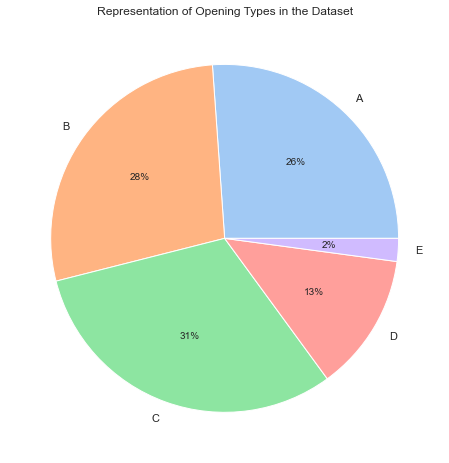

In [167]:
# creating a pie chart to display the representation of the chess openings types in the dataset

colors = sns.color_palette('pastel')
plt.figure(figsize = (22,8), facecolor = "#fff")
plt.pie(avg_elo_between_players_per_eco_fl['percentage_of_total'], labels = avg_elo_between_players_per_eco_fl.index, colors = colors, autopct='%.0f%%')
plt.title('Representation of Opening Types in the Dataset')
plt.show()

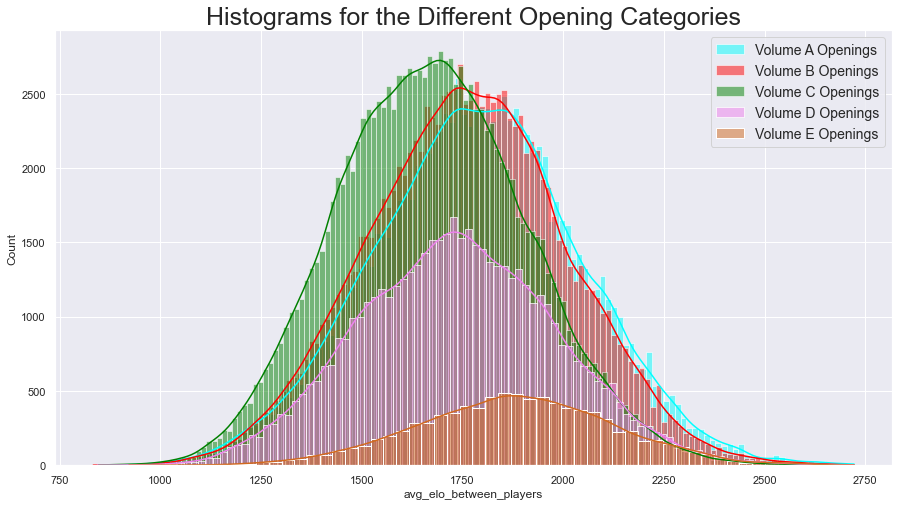

In [168]:
# creating histograms to portray the distribution of the average elos between players concerning the various opening categories

clean_df_A_openings = clean_df[clean_df['eco_fl'] == 'A']
clean_df_B_openings = clean_df[clean_df['eco_fl'] == 'B']
clean_df_C_openings = clean_df[clean_df['eco_fl'] == 'C']
clean_df_D_openings = clean_df[clean_df['eco_fl'] == 'D']
clean_df_E_openings = clean_df[clean_df['eco_fl'] == 'E']



sns.set(style = "darkgrid")

plt.figure(figsize = (15,8))

sns.histplot(data = clean_df_A_openings, x = "avg_elo_between_players", label = "Volume A Openings", color = "cyan", kde = True)
sns.histplot(data = clean_df_B_openings, x = "avg_elo_between_players", label = "Volume B Openings", color = "red", kde = True)
sns.histplot(data = clean_df_C_openings, x = "avg_elo_between_players", label = "Volume C Openings", color = "green", kde = True)
sns.histplot(data = clean_df_D_openings, x = "avg_elo_between_players", label = "Volume D Openings", color = "violet", kde = True)
sns.histplot(data = clean_df_E_openings, x = "avg_elo_between_players", label = "Volume E Openings", color = "chocolate", kde = True)

plt.legend(fontsize = 14)
plt.title("Histograms for the Different Opening Categories", fontsize = 25)
plt.show()

Note how Volume C has the highest count of games but also has a lower mean average elo between players value. Volume E on the other hand has a really low number of players
compared to the other volumes but its distribution's mean value is higher than the others (meaning fewer people play these openings, but the ones that do tend to be better players
on average).

***

In [169]:
# create an eco numbers column

clean_df['eco_#'] = clean_df['eco'].astype(str).str[1:3]
clean_df.head()

,event,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner_loser_elo_diff,eco,termination,time_control,avg_elo_between_players,eco_fl,eco_#
0,Rated Bullet game,1-0,1601,16.0,1793,-17.0,no_title,no_title,-192,A02,Time forfeit,120+1,1697.0,A,02
1,Rated Blitz tournament,0-1,1532,-12.0,1541,22.0,no_title,no_title,9,C45,Normal,300+0,1536.5,C,45
2,Rated Classical game,1-0,1646,11.0,1639,-11.0,no_title,no_title,7,C46,Normal,600+0,1642.5,C,46
3,Rated Blitz game,0-1,1757,-13.0,1659,14.0,no_title,no_title,-98,B00,Normal,300+0,1708.0,B,00
4,Rated Classical tournament,0-1,1829,-11.0,1857,11.0,no_title,no_title,28,A43,Normal,600+0,1843.0,A,43


## Looking at the Effectiveness of the Sicilian Defense

All variations of the Sicilian Defense start out with 1. e4 and 1. ... c5. The opening is an extremely popular response for Black against White's common 1. e4 as it immediately vies for control of the center in an asymmetrical fashion. The opening and its variations are known to be extremely dynamic and sharp, as well as giving Black quick and effective counterattacking opportunities against White. It is also known for its extreme complexity and vast amount of viable variations.

In [170]:
# the ECO (Encyclopedia of Chess Openings) labels all of the Sicilian Defense variations as ECO codes B20 - B99

sicilian_df = clean_df[clean_df['eco_#'].astype('int64').between(20, 99)]
sicilian_df = sicilian_df[sicilian_df['eco_fl'] == 'B']
sicilian_df.head()

,event,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner_loser_elo_diff,eco,termination,time_control,avg_elo_between_players,eco_fl,eco_#
7,Rated Classical tournament,0-1,1959,-11.0,1970,12.0,no_title,no_title,11,B30,Normal,600+0,1964.5,B,30
11,Rated Classical tournament,1/2-1/2,1890,0.0,1889,0.0,no_title,no_title,0,B27,Normal,600+0,1889.5,B,27
20,Rated Blitz tournament,0-1,1219,-7.0,1435,7.0,no_title,no_title,216,B20,Time forfeit,300+0,1327.0,B,20
23,Rated Blitz tournament,1-0,2110,13.0,2134,-13.0,no_title,no_title,-24,B21,Normal,300+0,2122.0,B,21
24,Rated Blitz tournament,0-1,1710,-12.0,1700,12.0,no_title,no_title,-10,B22,Time forfeit,300+0,1705.0,B,22


In [171]:
len(sicilian_df) / len(clean_df)

0.11660462799656401

Around 11.66% of the games in this dataset are with the Sicilian Defense.

Let's look at the percentages for White wins, Black wins, and draws in the total dataset vs games with the Sicilian.

In [172]:
# total dataset percentages
clean_df['result'].value_counts(normalize = True) * 100

1-0        49.689486
0-1        46.464999
1/2-1/2     3.845515
Name: result, dtype: float64

In [173]:
# sicilian dataset percentages
sicilian_df['result'].value_counts(normalize = True) * 100

0-1        50.653102
1-0        45.459235
1/2-1/2     3.887662
Name: result, dtype: float64

The Sicilian Defense appears to fare well for White, giving Black a slightly better win percentage than the average of all the openings together.

***

## Effect of Time Control on Victory Analysis

In [174]:
time_control_df = clean_df.copy()
time_control_df.head()

,event,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner_loser_elo_diff,eco,termination,time_control,avg_elo_between_players,eco_fl,eco_#
0,Rated Bullet game,1-0,1601,16.0,1793,-17.0,no_title,no_title,-192,A02,Time forfeit,120+1,1697.0,A,02
1,Rated Blitz tournament,0-1,1532,-12.0,1541,22.0,no_title,no_title,9,C45,Normal,300+0,1536.5,C,45
2,Rated Classical game,1-0,1646,11.0,1639,-11.0,no_title,no_title,7,C46,Normal,600+0,1642.5,C,46
3,Rated Blitz game,0-1,1757,-13.0,1659,14.0,no_title,no_title,-98,B00,Normal,300+0,1708.0,B,00
4,Rated Classical tournament,0-1,1829,-11.0,1857,11.0,no_title,no_title,28,A43,Normal,600+0,1843.0,A,43


First let's make sure that all games have the consistent time_control format of "number of minutes + increment per move." 

In [175]:
clean_df[clean_df['time_control'].str.find('+') == -1].head()

,event,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner_loser_elo_diff,eco,termination,time_control,avg_elo_between_players,eco_fl,eco_#
147,Rated Correspondence game,0-1,1551,-20.0,1534,22.0,no_title,no_title,-17,C26,Normal,-,1542.5,C,26
170,Rated Correspondence game,0-1,1195,-6.0,1688,1.0,no_title,no_title,493,B20,Time forfeit,-,1441.5,B,20
208,Rated Correspondence game,1-0,1659,14.0,1195,-7.0,no_title,no_title,464,C62,Time forfeit,-,1427.0,C,62
239,Rated Correspondence game,1-0,1500,91.0,1195,-30.0,no_title,no_title,305,C46,Time forfeit,-,1347.5,C,46
1133,Rated Correspondence game,1-0,1500,275.0,1735,-172.0,no_title,no_title,-235,D06,Normal,-,1617.5,D,06


In [176]:
clean_df[clean_df['time_control'].str.find('+') == -1]['event'].unique()

array(['Rated Correspondence game'], dtype=object)

In [177]:
len(clean_df[clean_df['event'] == 'Rated Correspondence game'])

1534

All of these are of the "Rated Correspondence game" type. These are games that are played over the course of days and thus here is no time control. There is also not that many of these games with respect to the entire working dataset so for this portion of the analysis, I will remove those and set a new dataframe.

In [178]:
time_control_df = clean_df[clean_df['event'] != 'Rated Correspondence game']
'Rated Correspondence Game' in time_control_df['event'].unique()

False

The time control formats for the games in this dataset are given in the form of "regular number of seconds + incremental seconds per move." 

In [179]:
clean_df['time_control'].value_counts()

300+0     69566
60+0      59313
180+0     57512
600+0     34885
30+0      21971
          ...  
300+14        1
960+1         1
60+150        1
840+12        1
120+40        1
Name: time_control, Length: 533, dtype: int64

The most 5 popular time control formats appear to be 5 minutes, 1 minute, 3 minutes, 10 minutes, and 30 seconds.

I will look at how the number of games ended by time forfeit increase as the amount of time for both sides is decreased.

In [180]:
split_list = time_control_df['time_control'].str.split('+')
split_list

0         [120, 1]
1         [300, 0]
2         [600, 0]
3         [300, 0]
4         [600, 0]
            ...   
417110    [180, 1]
417111     [30, 0]
417112    [300, 0]
417113     [60, 0]
417114    [480, 8]
Name: time_control, Length: 414067, dtype: object

In [243]:
regular_seconds_per_player = [item[0] for item in split_list] # as opposed to the incremental seconds per player; I am not going to worry about those for simplicity's sake
time_control_df['regular_seconds_per_player'] = regular_seconds_per_player
time_control_df.head()

,event,result,white_elo,white_rating_diff,black_elo,black_rating_diff,white_title,black_title,winner_loser_elo_diff,eco,termination,time_control,avg_elo_between_players,eco_fl,eco_#,regular_seconds_per_player
0,Rated Bullet game,1-0,1601,16.0,1793,-17.0,no_title,no_title,-192,A02,Time forfeit,120+1,1697.0,A,02,120
1,Rated Blitz tournament,0-1,1532,-12.0,1541,22.0,no_title,no_title,9,C45,Normal,300+0,1536.5,C,45,300
2,Rated Classical game,1-0,1646,11.0,1639,-11.0,no_title,no_title,7,C46,Normal,600+0,1642.5,C,46,600
3,Rated Blitz game,0-1,1757,-13.0,1659,14.0,no_title,no_title,-98,B00,Normal,300+0,1708.0,B,00,300
4,Rated Classical tournament,0-1,1829,-11.0,1857,11.0,no_title,no_title,28,A43,Normal,600+0,1843.0,A,43,600


In [304]:
time_forfeits_per_time_format = time_control_df[time_control_df['termination'] == 'Time forfeit']['regular_seconds_per_player'].value_counts().to_frame()
time_forfeits_per_time_format.rename_axis('regular_seconds_per_player', inplace = True)
time_forfeits_per_time_format.rename(columns = {'regular_seconds_per_player': 'games_lost_by_time_forfeit'}, inplace = True)
time_forfeits_per_time_format.index = pd.to_numeric(time_forfeits_per_time_format.index)
time_forfeits_per_time_format = time_forfeits_per_time_format.sort_index()
time_forfeits_per_time_format.head()

,games_lost_by_time_forfeit
regular_seconds_per_player,
0,3808
30,15600
45,873
60,35908
90,863


In [305]:
total_games_per_time_control_format = time_control_df['regular_seconds_per_player'].value_counts().to_frame()
total_games_per_time_control_format.rename_axis('regular_seconds_per_player', inplace = True)
total_games_per_time_control_format.rename(columns = {'regular_seconds_per_player': 'total_games'}, inplace = True)
total_games_per_time_control_format.index = pd.to_numeric(total_games_per_time_control_format.index)
total_games_per_time_control_format = total_games_per_time_control_format.sort_index()
total_games_per_time_control_format.head()

,total_games
regular_seconds_per_player,
0,7247
30,23672
45,2281
60,68362
90,2203


In [339]:
merged_time_forfeit_df = time_forfeits_per_time_format.merge(total_games_per_time_control_format, left_on = 'regular_seconds_per_player', right_on = 'regular_seconds_per_player')
merged_time_forfeit_df['proportion_percentage_lost_by_time'] = (merged_time_forfeit_df['games_lost_by_time_forfeit'] / merged_time_forfeit_df['total_games'] * 100).round(2)
merged_time_forfeit_df


,games_lost_by_time_forfeit,total_games,proportion_percentage_lost_by_time
regular_seconds_per_player,,,
0,3808,7247,52.55
30,15600,23672,65.90
45,873,2281,38.27
60,35908,68362,52.53
90,863,2203,39.17
120,10127,25363,39.93
180,22994,75400,30.50
240,2108,8073,26.11
300,23075,100903,22.87


Just a little sidenote: a value of "0" for the regular_seconds_per_player just means that the players are just playing with a time increment per side. 

In [361]:
fig = px.area(merged_time_forfeit_df, x = merged_time_forfeit_df.index, y = 'proportion_percentage_lost_by_time', 
    title = 'Percentage of Games Lost by Time for Time Alotted per Player', markers = True, 
    labels = {'regular_seconds_per_player': 'Time (s) per Player','proportion_percentage_lost_by_time': 'Percentage (%) of Games Lost by Time'})

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)
fig.update_layout(hovermode="x unified")
fig.show("png")

There appears to be a downward trend alotted time values below 2000 seconds, followed by an increase upward until 7200 seconds followed again by a downard trend. Let's look at the dataframe at and past 3600 seconds to investigate this further.

In [363]:
merged_time_forfeit_df[merged_time_forfeit_df.index >= 3600]

,games_lost_by_time_forfeit,total_games,proportion_percentage_lost_by_time
regular_seconds_per_player,,,
3600,87,437,19.91
5400,20,82,24.39
7200,11,34,32.35
9000,2,12,16.67
10800,43,214,20.09


Games with alotted time values of 5400, 7200, and 9000 have fewer total games have significantly fewer games than the rest of the categories.  Some error could exist here because of the relatively smaller sizes in these groups, thus explaining the upward trend in the proportions of games lost by time seen in this subsect.

***